In [1]:
using AutoRisk
using AutoViz
using Colors
using PGFPlots
using Reel

In [2]:
# build scene
context = IntegratedContinuous(.1, 1)
veh_per_col = 3
col_xs = [10., 20., 50., 70.]
num_veh = length(col_xs) * veh_per_col + 1
# one lane roadway
num_lanes = 3
roadway = gen_straight_roadway(num_lanes, 1000.)
scene = Scene(num_veh)

beh_params = get_normal_behavior_params(lon_σ = 1.0, lat_σ = 0.1, response_time = 0.3)
models = Dict{Int, DriverModel}()

# 1: second vehicle, in the middle, moving at intermediate speed
ego_id = 1
models[ego_id] = build_driver(beh_params, context, num_veh)
base_speed = 10.
road_pos = 30.
road_idx = RoadIndex(proj(VecSE2(0.0, 3.0, 0.0), roadway))
veh_state = VehicleState(Frenet(road_idx, roadway), roadway, base_speed)
veh_state = move_along(veh_state, roadway, road_pos)
veh_def = VehicleDef(ego_id, AgentClass.CAR, 5., 2.)
push!(scene, Vehicle(veh_state, veh_def))

# cols
for col_idx in 1:length(col_xs)
    for veh_idx in 1:veh_per_col
        veh_id = (col_idx - 1) * veh_per_col + veh_idx
        models[veh_id] = build_driver(beh_params, context, num_veh)
        base_speed = 10. + rand()
        road_pos = col_xs[col_idx]
        road_idx = RoadIndex(proj(VecSE2(0.0, (veh_idx - 1) * 3.0, 0.0), roadway))
        veh_state = VehicleState(Frenet(road_idx, roadway), roadway, base_speed)
        veh_state = move_along(veh_state, roadway, road_pos)
        veh_def = VehicleDef(veh_id, AgentClass.CAR, 5., 2.)
        push!(scene, Vehicle(veh_state, veh_def));
    end
end

Interact.Options{:ToggleButtons,Float64}(Signal{Float64}(5.0, nactions=1),"zoom",5.0,"5.0",Interact.OptionDict(DataStructures.OrderedDict("5.0"=>5.0,"6.0"=>6.0,"7.0"=>7.0,"8.0"=>8.0,"9.0"=>9.0,"10.0"=>10.0),Dict(7.0=>"7.0",9.0=>"9.0",10.0=>"10.0",5.0=>"5.0",8.0=>"8.0",6.0=>"6.0")),Any[],Any[],true,"horizontal")

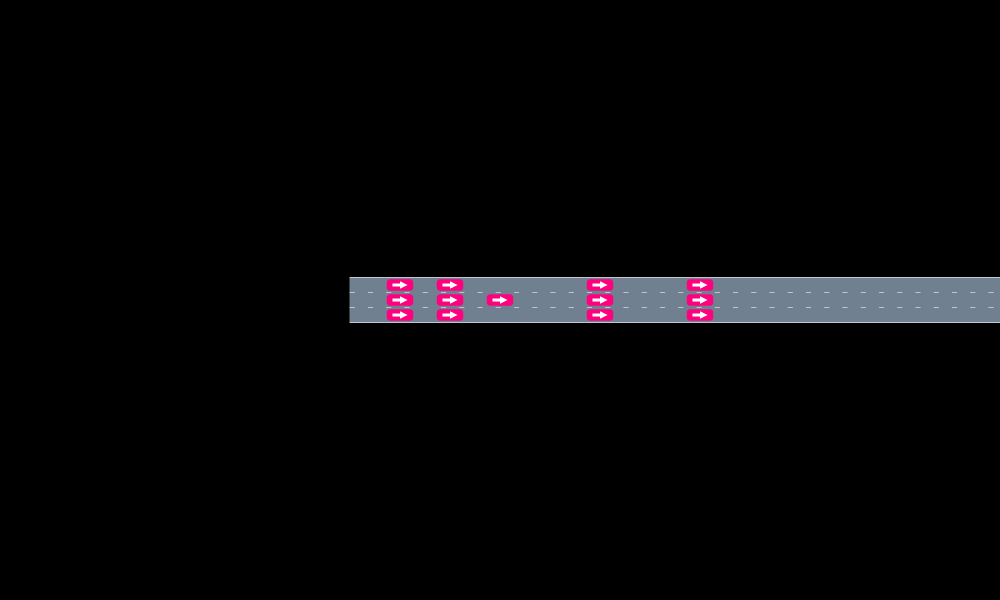

In [3]:
@manipulate for zoom in collect(5:10.)
    render(scene, roadway, cam = CarFollowCamera(1, zoom))
end

In [4]:
# build evaluator
num_runs = 10
prime_time = .3
sampling_time = .1
veh_idx_can_change = false
target_dim = 5
input_dim = 204
subexts = [
        CoreFeatureExtractor(),
        TemporalFeatureExtractor(),
        WellBehavedFeatureExtractor(),
        NeighborFeatureExtractor(),
        BehavioralFeatureExtractor(),
        NeighborBehavioralFeatureExtractor(),
        CarLidarFeatureExtractor()
    ]
ext = MultiFeatureExtractor(subexts)
rec = SceneRecord(500, .1, num_veh)
features = Array{Float64}(length(ext), 1, num_veh)
targets = Array{Float64}(target_dim, num_veh)
agg_targets = Array{Float64}(target_dim, num_veh)
rng = MersenneTwister(1)
eval = MonteCarloEvaluator(ext, num_runs, context, prime_time, sampling_time,
    veh_idx_can_change, rec, features, targets, agg_targets, rng);

In [5]:
# build network
network_filepath = "../../data/networks/risk_.1_sec_no_bn.weights"
network = Network(network_filepath);
# weights = h5open(network_filepath, "r") do file
#         read(file, "weights")
#     end

AutoRisk.Network(Array{Float64,N}[
[-0.0397121 -0.0815609 … 0.150424 -0.0200559; 0.0013088 0.0063575 … 0.00170937 -0.0190568; … ; -0.0129117 -0.01252 … -0.00514602 -0.0396848; 0.125517 -0.00537192 … 0.0158745 0.029969],

[-0.0326173 0.283122 … 0.136105 0.108882; 0.0160935 0.00825714 … -0.0637221 0.0643407; … ; -0.208523 0.00287288 … 0.260934 0.0129518; 0.0548512 0.290813 … 0.309342 -0.381622],

[0.235402 0.185596 … -0.157691 0.0774144; -0.295033 -0.340826 … -0.179801 -0.243177; … ; -0.278811 -0.237132 … -0.0957286 -0.227949; 0.236416 -0.291811 … -0.2832 0.221117]],Array{Float64,N}[
[0.127117 0.0545522 … 0.430474 0.262866],

[0.0578299 0.173225 … 0.303824 0.0672817],

[-0.0765232 -0.0857458 … -0.0875422 -0.0789838]],AutoRisk.relu!,[-1.7877e-5 -9.75343e-6 … -0.0925038 0.113813],[0.0402005 0.0123202 … 3.38441 2.42189])

In [6]:
# evaluate variations of the scene, keeping track of results
front_xs = linspace(-5, 45, 10)
front_ys = linspace(0,(num_lanes-1) * 3., 10)
target_probs = zeros(num_runs, target_dim, length(front_xs), length(front_ys))
net_target_probs = zeros(target_dim, length(front_xs), length(front_ys))
temp_scene = Scene()
eval.veh_id_to_idx = Dict(ego_id=>ego_id)
base_speed = 10.
frames = []
for (i, front_x) in enumerate(front_xs)
    for (j, front_y) in enumerate(front_ys)
        for run in 1:eval.num_runs
            empty!(eval.rec)
            copy!(temp_scene, scene)

            road_idx = RoadIndex(proj(VecSE2(0.0, 0.0, 0.0), roadway))
            veh_state = VehicleState(Frenet(road_idx, roadway, t=front_y), roadway, base_speed)
            veh_state = move_along(veh_state, roadway, front_x + temp_scene.vehicles[ego_id].state.posF.s)
            temp_scene.vehicles[6].state = veh_state
            
            # prime
            simulate!(temp_scene, models, roadway, eval.rec, eval.prime_time)
            
            # collect frame, features, pred targets
            if run == 1
                push!(frames, render(temp_scene, roadway, cam = CarFollowCamera(ego_id, 10.)))
                eval.features[:, 1, ego_id] = pull_features!(eval.ext, eval.rec, roadway, ego_id, models)
                net_target_probs[:, i, j] = predict(network, reshape(eval.features[:, 1, ego_id], (1, input_dim)))
            end
            
            # sample
            simulate!(temp_scene, models, roadway, eval.rec, eval.sampling_time)
            extract_targets!(eval.rec, roadway, eval.targets, eval.veh_id_to_idx, eval.veh_idx_can_change)
            target_probs[run, :, i, j] = eval.targets[:, ego_id]
        end
    end
end

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(50, nactions=1),"i",50,"50",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(68=>"68",2=>"2",89=>"89",11=>"11",39=>"39",46=>"46",85=>"85",25=>"25",55=>"55",42=>"42"…)),Any[],Any[],true,"horizontal")

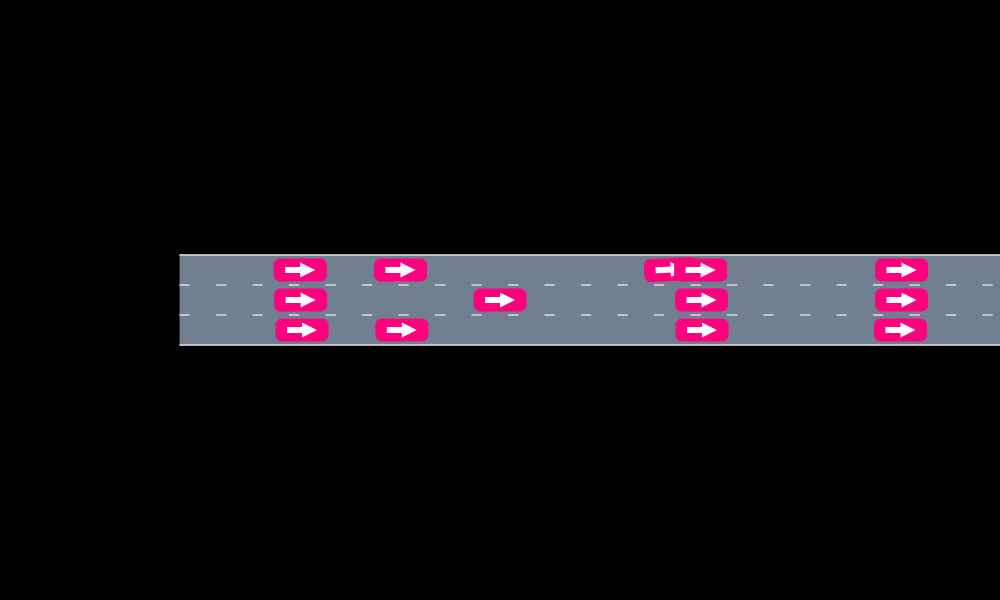

In [7]:
@manipulate for i in 1:length(frames)
    frames[i]
end

Interact.Options{:ToggleButtons,Float64}(Signal{Float64}(1.0, nactions=1),"zoom",1.0,"1.0",Interact.OptionDict(DataStructures.OrderedDict("1.0"=>1.0,"3.0"=>3.0,"5.0"=>5.0,"7.0"=>7.0,"9.0"=>9.0,"11.0"=>11.0,"13.0"=>13.0,"15.0"=>15.0,"17.0"=>17.0,"19.0"=>19.0…),Dict(7.0=>"7.0",9.0=>"9.0",13.0=>"13.0",3.0=>"3.0",19.0=>"19.0",17.0=>"17.0",11.0=>"11.0",5.0=>"5.0",15.0=>"15.0",1.0=>"1.0"…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(2, nactions=1),"i",2,"2",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3),Dict(2=>"2",3=>"3",1=>"1")),Any[],Any[],true,"horizontal")

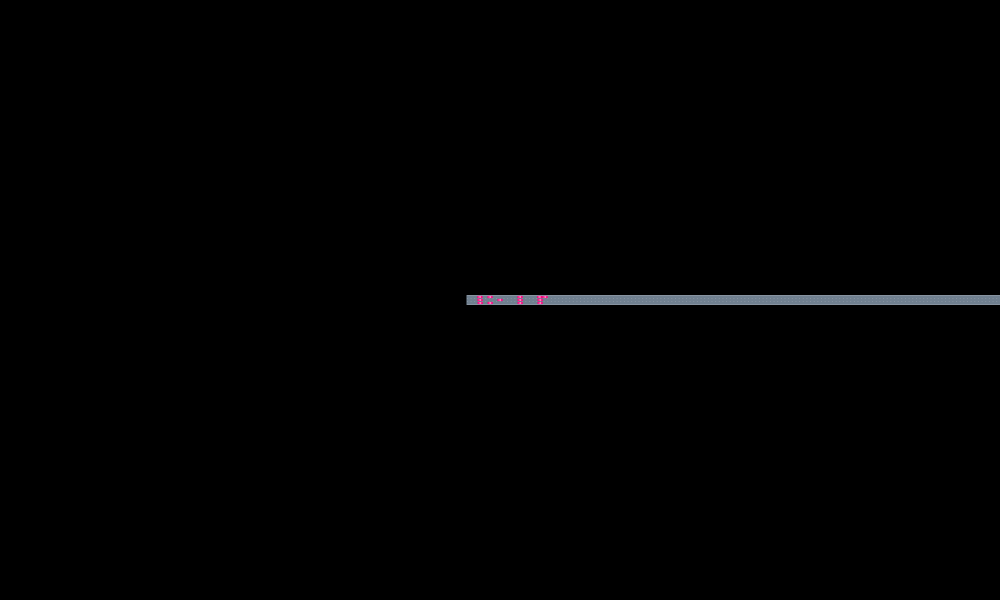

In [8]:
@manipulate for zoom in collect(1.:2:20.),
                i in 1:(eval.rec.nscenes)
    idx = -(eval.rec.nscenes - i) + 1
    render(get_scene(eval.rec, idx), roadway, cam = CarFollowCamera(ego_id, zoom))
end

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(5, nactions=1),"runs",5,"5",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(7=>"7",4=>"4",9=>"9",10=>"10",2=>"2",3=>"3",5=>"5",8=>"8",6=>"6",1=>"1"…)),Any[],Any[],true,"horizontal")

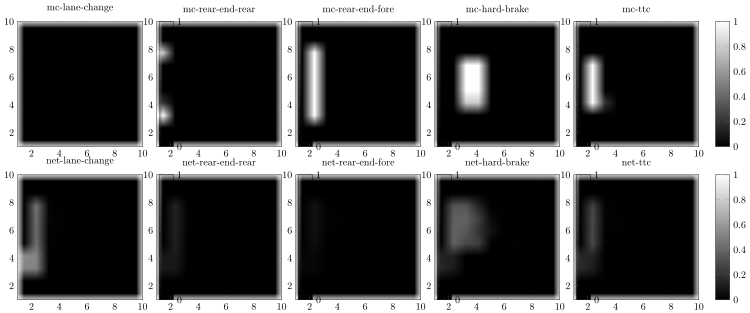

In [10]:
num_x_bins = length(front_xs)
num_y_bins = length(front_ys)
frames = []
mean_target_probs = zeros(size(target_probs))
for runs in 1:num_runs
    mean_target_probs[runs, :, :, :] = mean(target_probs[1:runs, :, :, :], 1)
end
@manipulate for runs in 1:num_runs
    
    get_mc_heat_lane_change(x::Float64, y::Float64) = mean_target_probs[runs, 1, Int(floor(x)), Int(floor(y))]
    get_net_heat_lane_change(x::Float64, y::Float64) = net_target_probs[1, Int(floor(x)), Int(floor(y))]
    
    get_mc_heat_rear_end_rear(x::Float64, y::Float64) = mean_target_probs[runs, 2, Int(floor(x)), Int(floor(y))]
    get_net_heat_rear_end_rear(x::Float64, y::Float64) = net_target_probs[2, Int(floor(x)), Int(floor(y))]
    
    get_mc_heat_rear_end_fore(x::Float64, y::Float64) = mean_target_probs[runs, 3, Int(floor(x)), Int(floor(y))]
    get_net_heat_rear_end_fore(x::Float64, y::Float64) = net_target_probs[3, Int(floor(x)), Int(floor(y))]
    
    get_mc_heat_hard_brake(x::Float64, y::Float64) = mean_target_probs[runs, 4, Int(floor(x)), Int(floor(y))]
    get_net_heat_hard_brake(x::Float64, y::Float64) = net_target_probs[4, Int(floor(x)), Int(floor(y))]
    
    get_mc_heat_ttc(x::Float64, y::Float64) = mean_target_probs[runs, 5, Int(floor(x)), Int(floor(y))]
    get_net_heat_ttc(x::Float64, y::Float64) = net_target_probs[5, Int(floor(x)), Int(floor(y))]
    
    g = GroupPlot(5,2,groupStyle = "horizontal sep = .5cm, vertical sep = 1cm")
    funcs = [get_mc_heat_lane_change, get_mc_heat_rear_end_rear, get_mc_heat_rear_end_fore, get_mc_heat_hard_brake, get_mc_heat_ttc,
        get_net_heat_lane_change, get_net_heat_rear_end_rear, get_net_heat_rear_end_fore, get_net_heat_hard_brake, get_net_heat_ttc]
    titles = ["mc-lane-change", "mc-rear-end-rear", "mc-rear-end-fore", "mc-hard-brake", "mc-ttc",
        "net-lane-change", "net-rear-end-rear", "net-rear-end-fore", "net-hard-brake", "net-ttc"]
    for (func, title) in zip(funcs, titles)
        a = Axis(
        [
            Plots.Image(func, (1, num_x_bins), (1, num_y_bins), 
                xbins = num_x_bins, ybins = num_y_bins, colorbar = true, zmin = 0, zmax = 1)
        ], 
            width="6cm", 
            height="6cm",
            title=string("$(title)")
        )
        push!(g, a)
    end
    
    g
end